Epoch [1/10], Train Loss: 2.8560, Validation Loss: 1.8120, Train Accuracy: 0.2225, Validation Accuracy: 0.4949
Epoch [2/10], Train Loss: 1.6340, Validation Loss: 0.8974, Train Accuracy: 0.5357, Validation Accuracy: 0.7632
Epoch [3/10], Train Loss: 0.9717, Validation Loss: 0.5298, Train Accuracy: 0.7094, Validation Accuracy: 0.8534
Epoch [4/10], Train Loss: 0.7238, Validation Loss: 0.3209, Train Accuracy: 0.7777, Validation Accuracy: 0.9250
Epoch [5/10], Train Loss: 0.5243, Validation Loss: 0.2463, Train Accuracy: 0.8394, Validation Accuracy: 0.9397
Epoch [6/10], Train Loss: 0.3981, Validation Loss: 0.1413, Train Accuracy: 0.8790, Validation Accuracy: 0.9713
Epoch [7/10], Train Loss: 0.3391, Validation Loss: 0.1370, Train Accuracy: 0.8944, Validation Accuracy: 0.9684
Epoch [8/10], Train Loss: 0.2794, Validation Loss: 0.1123, Train Accuracy: 0.9109, Validation Accuracy: 0.9701
Epoch [9/10], Train Loss: 0.2467, Validation Loss: 0.0890, Train Accuracy: 0.9222, Validation Accuracy: 0.9780
E

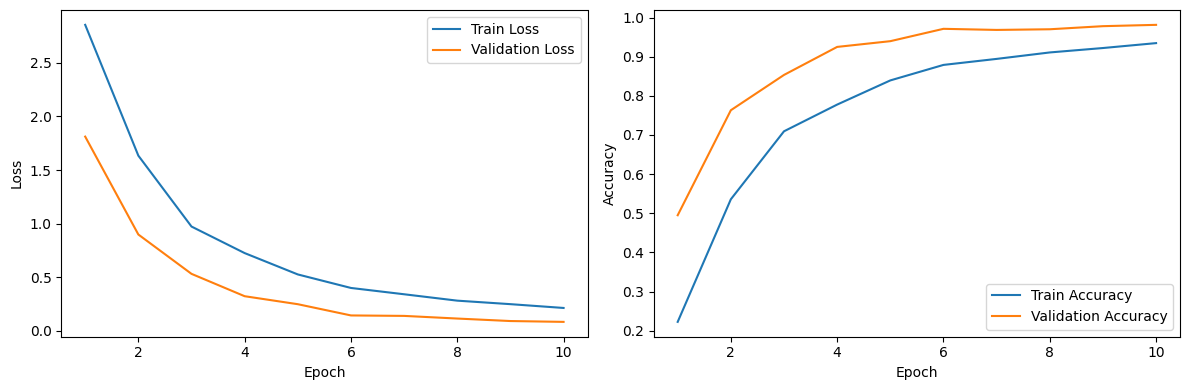

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandomApply, RandomHorizontalFlip, RandomRotation
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class HandSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HandSignClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Set hyperparameters
batch_size = 48
learning_rate = 0.001
num_epochs = 10
patience = 3  # Number of epochs to wait for improvement before early stopping

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomApply([RandomRotation(10)]),
    RandomApply([RandomHorizontalFlip()]),
    transforms.Grayscale(),  # Convert to black and white
    transforms.ToTensor(),
])

# Load dataset and split into training, validation, and testing sets
full_dataset = datasets.ImageFolder(root="E:/something/Major-project/pre-images", transform=transform)

# Define the sizes for training, validation, and testing sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Access classes from the underlying dataset
num_classes = len(full_dataset.classes)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = HandSignClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping setup
best_accuracy = 0.0
counter = 0

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        accuracy_val = total_correct_val / total_samples_val
        val_accuracies.append(accuracy_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {accuracy:.4f}, Validation Accuracy: {accuracy_val:.4f}')

    # Early stopping check and model checkpoint
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        counter = 0
        # Save the model if desired
        torch.save(model.state_dict(), 'hand_sign_classifier_best.pth')

    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {counter} epochs without improvement.")
            break

# Plot the learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend() 

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'hand_sign_classifier_final.pth')


Epoch [1/10], Train Loss: 1.1565, Validation Loss: 0.3602, Train Accuracy: 0.5986, Validation Accuracy: 0.8894
Epoch [2/10], Train Loss: 0.3457, Validation Loss: 0.1445, Train Accuracy: 0.8827, Validation Accuracy: 0.9574
Epoch [3/10], Train Loss: 0.1694, Validation Loss: 0.0726, Train Accuracy: 0.9430, Validation Accuracy: 0.9766
Epoch [4/10], Train Loss: 0.1002, Validation Loss: 0.0733, Train Accuracy: 0.9638, Validation Accuracy: 0.9809
Epoch [5/10], Train Loss: 0.1000, Validation Loss: 0.1014, Train Accuracy: 0.9659, Validation Accuracy: 0.9638
Epoch [6/10], Train Loss: 0.0684, Validation Loss: 0.0760, Train Accuracy: 0.9733, Validation Accuracy: 0.9745
Epoch [7/10], Train Loss: 0.0516, Validation Loss: 0.0531, Train Accuracy: 0.9845, Validation Accuracy: 0.9872
Epoch [8/10], Train Loss: 0.0530, Validation Loss: 0.0607, Train Accuracy: 0.9851, Validation Accuracy: 0.9851
Epoch [9/10], Train Loss: 0.0547, Validation Loss: 0.0377, Train Accuracy: 0.9835, Validation Accuracy: 0.9830
E

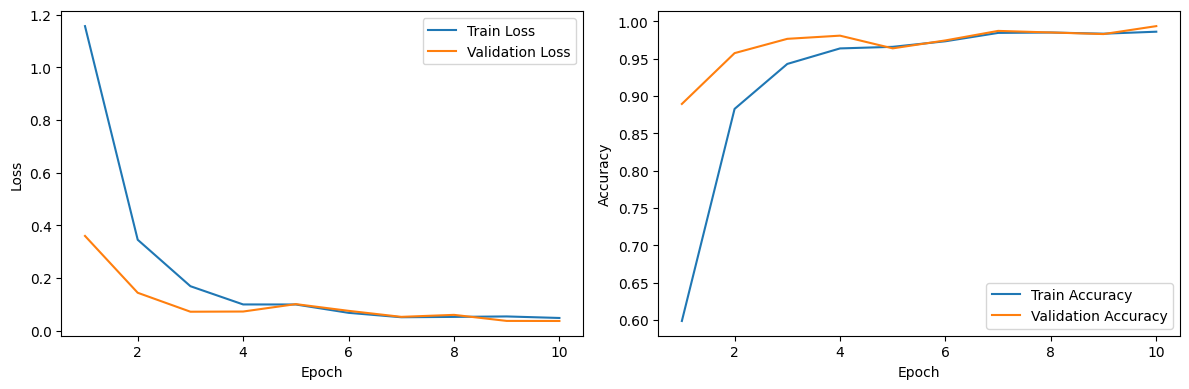

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandomApply, RandomHorizontalFlip, RandomRotation
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class HandSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HandSignClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Set hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 10
patience = 3  # Number of epochs to wait for improvement before early stopping

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomApply([RandomRotation(10)]),
    RandomApply([RandomHorizontalFlip()]),
    transforms.Grayscale(),  # Convert to black and white
    transforms.ToTensor(),
])

# Load dataset and split into training, validation, and testing sets
full_dataset = datasets.ImageFolder(root="E:/Downloads/vowel_images-20240222T095353Z-001/vow-img", transform=transform)

# Define the sizes for training, validation, and testing sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Access classes from the underlying dataset
num_classes = len(full_dataset.classes)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = HandSignClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping setup
best_accuracy = 0.0
counter = 0

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        accuracy_val = total_correct_val / total_samples_val
        val_accuracies.append(accuracy_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {accuracy:.4f}, Validation Accuracy: {accuracy_val:.4f}')

    # Early stopping check and model checkpoint
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        counter = 0
        # Save the model if desired
        torch.save(model.state_dict(), 'hand_sign_classifier_best_vowel.pth')

    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {counter} epochs without improvement.")
            break

# Plot the learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend() 

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'hand_sign_classifier_final_vowel.pth')


Epoch [1/10], Train Loss: 1.1093, Validation Loss: 0.3600, Train Accuracy: 0.6242, Validation Accuracy: 0.8915
Epoch [2/10], Train Loss: 0.3120, Validation Loss: 0.1426, Train Accuracy: 0.9014, Validation Accuracy: 0.9511
Epoch [3/10], Train Loss: 0.1863, Validation Loss: 0.0702, Train Accuracy: 0.9376, Validation Accuracy: 0.9723
Epoch [4/10], Train Loss: 0.1325, Validation Loss: 0.0636, Train Accuracy: 0.9606, Validation Accuracy: 0.9702
Epoch [5/10], Train Loss: 0.1091, Validation Loss: 0.0275, Train Accuracy: 0.9659, Validation Accuracy: 0.9872
Epoch [6/10], Train Loss: 0.0778, Validation Loss: 0.0212, Train Accuracy: 0.9749, Validation Accuracy: 0.9915
Epoch [7/10], Train Loss: 0.0648, Validation Loss: 0.1066, Train Accuracy: 0.9808, Validation Accuracy: 0.9702
Epoch [8/10], Train Loss: 0.0688, Validation Loss: 0.0130, Train Accuracy: 0.9749, Validation Accuracy: 0.9936
Epoch [9/10], Train Loss: 0.0661, Validation Loss: 0.0082, Train Accuracy: 0.9755, Validation Accuracy: 1.0000
E

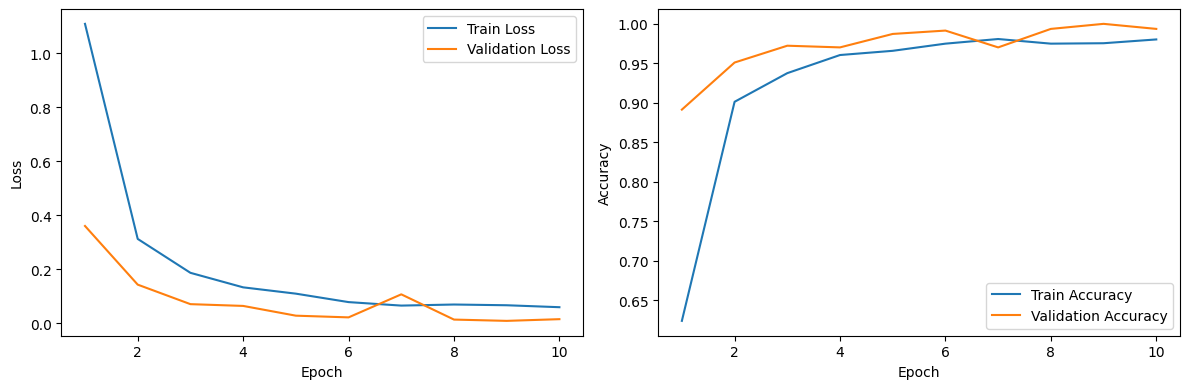

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandomApply, RandomHorizontalFlip, RandomRotation
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class HandSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HandSignClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Set hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 10
patience = 3  # Number of epochs to wait for improvement before early stopping

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomApply([RandomRotation(10)]),
    RandomApply([RandomHorizontalFlip()]),
    transforms.Grayscale(),  # Convert to black and white
    transforms.ToTensor(),
])

# Load dataset and split into training, validation, and testing sets
full_dataset = datasets.ImageFolder(root="E:/Downloads/vowel_images-20240222T095353Z-001/vow-img", transform=transform)

# Define the sizes for training, validation, and testing sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Access classes from the underlying dataset
num_classes = len(full_dataset.classes)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = HandSignClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping setup
best_accuracy = 0.0
counter = 0

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        accuracy_val = total_correct_val / total_samples_val
        val_accuracies.append(accuracy_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {accuracy:.4f}, Validation Accuracy: {accuracy_val:.4f}')

    # Early stopping check and model checkpoint
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        counter = 0
        # Save the model if desired
        torch.save(model.state_dict(), 'hand_sign_classifier_best_vowel-bs16.pth')

    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {counter} epochs without improvement.")
            break

# Plot the learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend() 

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'hand_sign_classifier_final_vowel-bs16.pth')


Epoch [1/10], Train Loss: 1.0921, Validation Loss: 0.2119, Train Accuracy: 0.6306, Validation Accuracy: 0.9213
Epoch [2/10], Train Loss: 0.3044, Validation Loss: 0.1394, Train Accuracy: 0.9014, Validation Accuracy: 0.9617
Epoch [3/10], Train Loss: 0.1962, Validation Loss: 0.0613, Train Accuracy: 0.9323, Validation Accuracy: 0.9872
Epoch [4/10], Train Loss: 0.1348, Validation Loss: 0.0767, Train Accuracy: 0.9595, Validation Accuracy: 0.9787
Epoch [5/10], Train Loss: 0.0856, Validation Loss: 0.0391, Train Accuracy: 0.9765, Validation Accuracy: 0.9872
Epoch [6/10], Train Loss: 0.0776, Validation Loss: 0.0462, Train Accuracy: 0.9739, Validation Accuracy: 0.9851
Early stopping after 3 epochs without improvement.


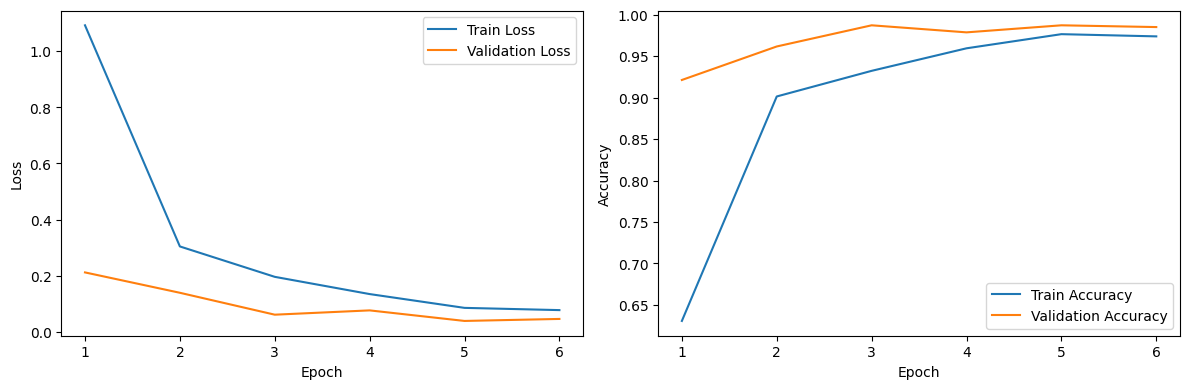

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandomApply, RandomHorizontalFlip, RandomRotation
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class HandSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HandSignClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Set hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 10
patience = 3  # Number of epochs to wait for improvement before early stopping

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomApply([RandomRotation(10)]),
    RandomApply([RandomHorizontalFlip()]),
    transforms.Grayscale(),  # Convert to black and white
    transforms.ToTensor(),
])

# Load dataset and split into training, validation, and testing sets
full_dataset = datasets.ImageFolder(root="E:/Downloads/vowel_images-20240222T095353Z-001/vow-img", transform=transform)

# Define the sizes for training, validation, and testing sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Access classes from the underlying dataset
num_classes = len(full_dataset.classes)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = HandSignClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping setup
best_accuracy = 0.0
counter = 0

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        accuracy_val = total_correct_val / total_samples_val
        val_accuracies.append(accuracy_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {accuracy:.4f}, Validation Accuracy: {accuracy_val:.4f}')

    # Early stopping check and model checkpoint
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        counter = 0
        # Save the model if desired
        torch.save(model.state_dict(), 'hand_sign_classifier_best_vowel1.pth')

    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {counter} epochs without improvement.")
            break

# Plot the learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend() 

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'hand_sign_classifier_final_vowel1.pth')


Epoch [1/10], Train Loss: 3.0341, Validation Loss: 1.9451, Train Accuracy: 0.1789, Validation Accuracy: 0.5011
Epoch [2/10], Train Loss: 1.7476, Validation Loss: 1.0168, Train Accuracy: 0.5030, Validation Accuracy: 0.7401
Epoch [3/10], Train Loss: 1.1978, Validation Loss: 0.7145, Train Accuracy: 0.6509, Validation Accuracy: 0.8083
Epoch [4/10], Train Loss: 0.9430, Validation Loss: 0.5420, Train Accuracy: 0.7179, Validation Accuracy: 0.8647
Epoch [5/10], Train Loss: 0.7617, Validation Loss: 0.4376, Train Accuracy: 0.7733, Validation Accuracy: 0.8895
Epoch [6/10], Train Loss: 0.6153, Validation Loss: 0.3529, Train Accuracy: 0.8140, Validation Accuracy: 0.9036
Epoch [7/10], Train Loss: 0.5477, Validation Loss: 0.2686, Train Accuracy: 0.8305, Validation Accuracy: 0.9194
Epoch [8/10], Train Loss: 0.4808, Validation Loss: 0.2380, Train Accuracy: 0.8510, Validation Accuracy: 0.9402
Epoch [9/10], Train Loss: 0.4204, Validation Loss: 0.1909, Train Accuracy: 0.8717, Validation Accuracy: 0.9566
E

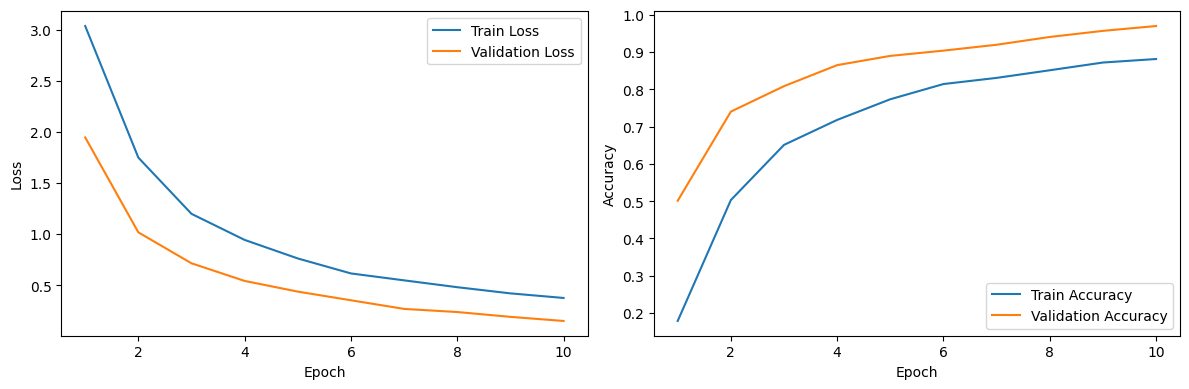

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandomApply, RandomHorizontalFlip, RandomRotation
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class HandSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HandSignClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Set hyperparameters
batch_size = 48
learning_rate = 0.001
num_epochs = 10
patience = 3  # Number of epochs to wait for improvement before early stopping

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomApply([RandomRotation(10)]),
    RandomApply([RandomHorizontalFlip()]),
    transforms.Grayscale(),  # Convert to black and white
    transforms.ToTensor(),
])

# Load dataset and split into training, validation, and testing sets
full_dataset = datasets.ImageFolder(root="E:/something/Major-project/pre-images", transform=transform)

# Define the sizes for training, validation, and testing sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Access classes from the underlying dataset
num_classes = len(full_dataset.classes)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = HandSignClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping setup
best_accuracy = 0.0
counter = 0

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        accuracy_val = total_correct_val / total_samples_val
        val_accuracies.append(accuracy_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {accuracy:.4f}, Validation Accuracy: {accuracy_val:.4f}')

    # Early stopping check and model checkpoint
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        counter = 0
        # Save the model if desired
        torch.save(model.state_dict(), 'hand_sign_classifier_best1.pth')

    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {counter} epochs without improvement.")
            break

# Plot the learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend() 

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'hand_sign_classifier_final1.pth')
